In [0]:
!pip install supabase

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from supabase import create_client, Client
from sklearn.feature_extraction.text import TfidfTransformer

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdc11015260>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [0]:

# get supabase_url and supabase_api_key usings databricks secrets
supabase_url = dbutils.secrets.get(scope='rippl', key='supabase_url')
supabase_key = dbutils.secrets.get(scope='rippl', key='supabase_api_key')

# establish connection with supabase backend
supabase : Client = create_client(supabase_url, supabase_key)

In [0]:
def pull_full_table(table_name):
    # got tired of writing this out multiple times so even though it's more clunkly in jupyter notebooks I made a function for this

    # error handling
    # can I check if table doesn't exist in supabase? 

    # get total count of rows
    response = supabase.table(table_name).select("*", count="exact").execute()
    total_count = response.count

    # calculate num_batches
    num_batches = (total_count // 1000) + 1 # can only pull 1000 per batch 

    # print outputs to validate
    print(f"Total Rows in Table: {total_count}")
    print(f"Num Batches to get Total Rows {num_batches}")

    # actually do the loop

    for batch in range(1, num_batches + 1): # start at 1 (or start variable equation doesn't work)
        
        # get start and end of 'range' of rows to call in table
        start = (batch - 1) * 1000  # eg. first batch, will be 0
        end = (batch * 1000) - 1 # eg. first batch, will be 999 (unless less than 999)
        if  end > total_count:
            end = total_count
        
        # print outputs to validate
        print(f"For batch: {batch}, start: {start}, end: {end}")

        # get rows in range(start, end)
        temp_response = supabase.table(table_name).select("*").range(start, end).execute() 

        # get data
        temp_data = temp_response.data
        
        # convert to pandas dataframe for easy handling
        temp_df = pd.DataFrame(temp_data)

        # concatenate (or if batch one, copy)
        if batch == 1:
            result_df = temp_df.copy()

        else:
            result_df = pd.concat([result_df, temp_df], axis=0)

    # reset index and remove prior index
    result_df.reset_index(drop=True, inplace=True)

    return result_df

def check_oldest_timestamp(old_recs_df, day_threshold=7):
    old_copy = old_recs_df.copy()
    
    old_copy['timestamp'] = pd.to_datetime(old_copy['timestamp'], errors='coerce')

    oldest_ts = old_copy['timestamp'].min()


    day_threshold = datetime.now() - timedelta(days=day_threshold)

    if oldest_ts <= day_threshold:
        print("old_recs_df is older than day threshold set, it should be deleted")
        return True
    else:
        print("old_recs_df is not older than day threshold set, it should be kept")
        return False

def delete_table(table_name):
    # so apparently whenever supabase runs a delete command it needs a 'where' command
    # but the way around this is just to run the neq command -- which I guess is looking for a case where 
    # user_id is the 'dummy_id' to make sure it doesn't delete that one
    # but because the dummy_id is intentionally something that shouldn't be a uuid
    # it ends up deleting the whole table 
    dummy_id = "00000000-0000-0000-0000-000000000000"
    response = supabase.table(table_name).delete().neq("user_id", dummy_id).execute()
    print("Deletion response:", response)





def get_user_user_recommendations(similarity_df):
    # generating recommendations 
    recommendation_rows = []

    for user in similarity_df.index:

        user_similarities = similarity_df.loc[user]

        user_similarities = user_similarities[user_similarities.index != user] # removing the user_id in question from results
        user_similarities = user_similarities[user_similarities > 0] # removing zero values

        # sort by descending similarity
        user_similarities = user_similarities.sort_values(ascending=False) 

        # build list of recommendation records
        for recommended_user, sim_score in user_similarities.items():

            recommendation_rows.append({
                "user_id": user,
                "recommended_user_id": recommended_user,
                "has_been_recommended": True,  
                "similarity_score": int(sim_score * 1000), # converting sub 1 float to 1000 integer
                "timestamp": datetime.utcnow().isoformat(),  # current time converted to ISO string so it can be JSON serializable
                "embedding": None  # has to be json serializable? Not sure what it means for an embeding to be json serializable
            })

    recommendations_df = pd.DataFrame(recommendation_rows)
    return recommendations_df

def get_similarity_df(user_interest_matrix_unprocessed):
    # attempting to use tfidf vectors to do simple content filtering 
    user_interest_matrix_tfidf = user_interest_matrix_unprocessed.copy()
    user_interest_matrix_tfidf.fillna(0, inplace=True)
    user_interest_matrix_tfidf

    tfidf_transformer = TfidfTransformer()
    user_interests_tfidf = tfidf_transformer.fit_transform(user_interest_matrix_tfidf.values).toarray()
    user_interests_tfidf

    user_vectors = user_interest_matrix_tfidf.values
    # seems dimensionality depends on the vocabulary size? Not sure how to make this a fixed number? 
    similarity_matrix = cosine_similarity(user_vectors, user_vectors)
    user_ids = user_interest_matrix_tfidf.index.tolist()
    similarity_df = pd.DataFrame(similarity_matrix, index=user_ids, columns=user_ids)
    return similarity_df

def compare_users(user1_id, user2_id, similarity_score):
    user1_data = merged_df[merged_df["user_id"] == user1_id]
    user2_data = merged_df[merged_df["user_id"] == user2_id]

    user1_interests = user1_data["name"].tolist()
    user2_interests = user2_data["name"].tolist()

    return user1_interests, user2_interests, similarity_score


def validate_user_user_recommendations(recommendations_df):
    similarity_scores = []
    overlap_counts = []

    count_no_overlap = 0

    for idx, row in recommendations_df.iterrows():
        user_id = row["user_id"]
        recommended_user_id = row['recommended_user_id']
        similarity_score = row['similarity_score']
        # if similarity_score > 100:
        user_interests, recommended_user_interests, similarity_score = compare_users(user_id, recommended_user_id, similarity_score)

        # Compute overlapping interests: interests that appear in both user's and recommended user's lists.
        overlapping_interests = [interest for interest in recommended_user_interests if interest in user_interests]
        
        # Get the count of overlapping interests.
        num_overlapping = len(overlapping_interests)
        if num_overlapping == 0:
            count_no_overlap += 1

        # Append the data for plotting.
        similarity_scores.append(similarity_score)
        overlap_counts.append(num_overlapping)

        print("__________________________________________________")
        print(f"Similarity score :", similarity_score)
        print(f"User Interests :", user_interests)
        print(f"REcommended_user_interests :" , recommended_user_interests)
        print(f"Number of overlapping interests :", num_overlapping)
        print(f"Overlapping interests :", overlapping_interests)

    print(f"N_times users with similarity scores didn't have overlapping interests :", count_no_overlap) 

    return similarity_scores, overlap_counts


def remove_duplicate_user_recommendations(new_df_original, old_df_original):

    #creating copies so I don't accidentally 
    new_df = new_df_original.copy()
    old_df = old_df_original.copy()

    if new_df.empty:
        print("new df empty, returning old")
        return old_df
    elif old_df.empty:
        print("old df empty, returning new")
        return new_df
    
    # converts all user_ids and recommended_user_ids to strings and strips trailing and leading whitespaces
    for col in ['user_id', 'recommended_user_id']:
        new_df[col] = new_df[col].astype(str).str.strip()
        old_df[col] = old_df[col].astype(str).str.strip()
    
    old_pairs = set(zip(old_df['user_id'], old_df['recommended_user_id']))

    mask = new_df.apply(lambda row: (row['user_id'], row['recommended_user_id']) not in old_pairs, axis=1)

    if not mask.any():
        print("new df is all duplicates of old df, returning old df")
        return old_df

    # using mask and applying mask to original new_df
    filtered_new_df = new_df_original[mask].reset_index(drop=True)

    return filtered_new_df

In [0]:
# getting and display users table
users_df = pull_full_table("users")
users_df

Total Rows in Table: 20
Num Batches to get Total Rows 1
For batch: 1, start: 0, end: 20


,id,name,image,description,email,created_at
0,897a4d99-a0d4-474a-b34d-78ab1e062a93,Sierra Trailson,[REDACTED]/stora...,Weekend wanderer and sunrise seeker. I hike to...,abrielle@rippl.world,2025-04-14T02:17:13.164935
1,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,Gregory Mcgregerson,[REDACTED]/stora...,Hi,johnrich398@gmail.com,2025-04-11T04:11:37.742094
2,a46c20e6-1c11-4a59-a70c-1cc22862885d,Savanna Davis,[REDACTED]/stora...,I love video games!,saavannaa.rose@gmail.com,2025-04-09T23:31:03.00942
3,449bc0ab-6942-426e-b573-9cb690ffd1b9,Sydney Blake,[REDACTED]/stora...,I live for fresh powder runs and cozy evenings...,dfalsabrook@gmail.com,2025-04-10T03:35:57.447764
4,3fb510a5-58a0-4994-81ba-29e69fa79db1,David Meddie,[REDACTED]/stora...,I really like cars!,david.meddaugh@atlasschool.com,2025-04-10T20:14:04.190027
5,c2c9fd5e-2040-4ee7-92ec-4bd65a467a27,Cody,[REDACTED]/stora...,,codywalenciak@gmail.com,2025-04-10T20:38:11.824933
6,740f8541-0638-4348-8fd9-72453613be4e,Natalie Baker,[REDACTED]/stora...,Lover of sweet treats and scenic trails. You’l...,abrielleperry22@icloud.com,2025-04-13T03:15:09.953282
7,7ca36877-fc2f-478e-951d-b4af878f25ef,Blake Renshaw,[REDACTED]/stora...,"Grew up in the garage, raised on horsepower an...",juvx6bpas6@knmcadibav.com,2025-04-15T17:12:07.099672
8,ecb95c11-4923-42d0-9a45-01eb27cb832a,Mike Rodgers,[REDACTED]/stora...,Old soul with a love for all things that move ...,david.alasbrook@atlasschool.com,2025-04-10T20:19:26.250657
9,3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,Carson Ridge,[REDACTED]/stora...,I’m a sculptor and ceramic artist who finds pe...,david.a@rippl.world,2025-04-10T04:13:53.414479


In [0]:
# getting and displaying user_interest table
user_interest_df = pull_full_table("user_interests")
user_interest_df

Total Rows in Table: 152
Num Batches to get Total Rows 1
For batch: 1, start: 0, end: 152


,user_id,interest_id
0,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,15bb36f9-7466-4e83-a148-5096114cce9e
1,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,62b86242-7014-499f-9cb9-42cfca036de9
2,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,6663208a-593c-4c58-8df2-1cf2fda3cce6
3,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,872755d5-698f-4b66-8e80-098c01ca96eb
4,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,96081371-66ce-49ef-adf7-a1f90b47fdb3
...,...,...
147,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,6117a58e-f12f-4af1-b031-da9fa32d0742
148,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c
149,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,baa13863-6091-4872-ba3d-b29a09af0d05
150,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,cbf7c5eb-44e3-4364-b5cd-a0ecd045ee3d


In [0]:
# getting and displaying interests table
interests_df = pull_full_table("interests")
interests_df

Total Rows in Table: 47
Num Batches to get Total Rows 1
For batch: 1, start: 0, end: 47


,id,name,category_id
0,03f7dc13-cd91-4eaf-95c2-59dc783c8e03,Math,324b188f-361a-416d-9f58-83b9a2e8606c
1,06b52f51-32a3-4921-948c-23cb1f474ca3,Pottery,53ea2977-9a06-4445-bc95-b6d8acf72010
2,0f790fe0-7859-4408-9b98-c8cee119d659,Knitting,53ea2977-9a06-4445-bc95-b6d8acf72010
3,15bb36f9-7466-4e83-a148-5096114cce9e,Yoga,3e50575e-4896-4cf1-a98b-35f629474335
4,17a74d46-88b0-40a8-afa8-bbca0d79d285,Rollerskating,384da8b9-33f2-4f22-83c7-fc05d8bf2298
5,1820882b-7561-4f92-9f8d-8c241be21cf6,Skiing,384da8b9-33f2-4f22-83c7-fc05d8bf2298
6,1888b454-b69e-46bf-bc92-24e6a1085518,Playing Instruments,9d5bd5f2-ec1d-46ca-9c75-0965c676d465
7,1f85d55e-0b0c-4dd7-a9b0-82e4cb699145,Cardio,3e50575e-4896-4cf1-a98b-35f629474335
8,31242d1e-66fe-43fb-8d48-06e751c50e32,Studying,324b188f-361a-416d-9f58-83b9a2e8606c
9,40ddb76d-be61-4b45-9ec1-1d917e3a08c0,Sewing,53ea2977-9a06-4445-bc95-b6d8acf72010


In [0]:


# interests_df['name] is columns of user_interest matrix
# users_df['user_id"] is rows of user_interest matrix
# if user_df['user_id'] has an interest in the column (interests_df['name']) then set the value to 1
# interest_id and user_id will have to be remapped
new_interest_id_map = {}
j = 0
for old in interests_df['id']:
  new_interest_id_map[old] = j
  j += 1

new_user_id_map = {}
i = 0
for old in users_df['id']:
    new_user_id_map[old] = i
    i += 1

new_interest_id_map

{'03f7dc13-cd91-4eaf-95c2-59dc783c8e03': 0,
 '06b52f51-32a3-4921-948c-23cb1f474ca3': 1,
 '0f790fe0-7859-4408-9b98-c8cee119d659': 2,
 '15bb36f9-7466-4e83-a148-5096114cce9e': 3,
 '17a74d46-88b0-40a8-afa8-bbca0d79d285': 4,
 '1820882b-7561-4f92-9f8d-8c241be21cf6': 5,
 '1888b454-b69e-46bf-bc92-24e6a1085518': 6,
 '1f85d55e-0b0c-4dd7-a9b0-82e4cb699145': 7,
 '31242d1e-66fe-43fb-8d48-06e751c50e32': 8,
 '40ddb76d-be61-4b45-9ec1-1d917e3a08c0': 9,
 '43888455-55cf-4c09-ad26-df7d4673e19c': 10,
 '44227a36-49a0-4f30-94dd-3dc1c4e0a951': 11,
 '4b57788f-1d57-4286-b760-14e6fbccf2f6': 12,
 '5bf4236f-11ed-4332-8bb5-c0cc009adc99': 13,
 '6117a58e-f12f-4af1-b031-da9fa32d0742': 14,
 '62b86242-7014-499f-9cb9-42cfca036de9': 15,
 '6663208a-593c-4c58-8df2-1cf2fda3cce6': 16,
 '6ad40466-14f4-4bbd-8d9c-a17590ab2f2c': 17,
 '6c22dd13-897c-4b98-95d0-32dda931a2d3': 18,
 '72a885d5-db6e-4148-9d2a-09347d948451': 19,
 '7e21b3d7-9a17-4e2a-aa69-a4feba8e7c84': 20,
 '7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c': 21,
 '86b64472-50ea-4d2e

In [0]:
new_user_id_map

{'897a4d99-a0d4-474a-b34d-78ab1e062a93': 0,
 '02c3c862-b8a5-4fde-ac56-e3b5545f18d6': 1,
 'a46c20e6-1c11-4a59-a70c-1cc22862885d': 2,
 '449bc0ab-6942-426e-b573-9cb690ffd1b9': 3,
 '3fb510a5-58a0-4994-81ba-29e69fa79db1': 4,
 'c2c9fd5e-2040-4ee7-92ec-4bd65a467a27': 5,
 '740f8541-0638-4348-8fd9-72453613be4e': 6,
 '7ca36877-fc2f-478e-951d-b4af878f25ef': 7,
 'ecb95c11-4923-42d0-9a45-01eb27cb832a': 8,
 '3e6acdeb-aa9a-47f1-879d-d7139eb98e2f': 9,
 'e13ae6de-0656-493c-9165-80c1b0cd9bf6': 10,
 'ec03cce8-e743-45af-97e9-71bc05588376': 11,
 'f8f9ec17-fb66-4689-abc2-529d61dfb1f4': 12,
 'eb88b8b4-bdea-4aa0-af25-ec728d4083e5': 13,
 '0b7249ca-cc82-4ff1-9d50-d8d61280b717': 14,
 '436c7907-3ded-4313-832a-831fd3259848': 15,
 '76e52c42-0d73-42b7-95c4-20aadcd886ae': 16,
 '45365d21-9977-4505-a0f0-7f090bc33747': 17,
 'a99e13b8-fc64-48c6-a502-72e91972c107': 18,
 '355e5f7c-87fa-45c4-a218-ff904b7a1128': 19}

In [0]:
user_interest_df['has_interest'] = 1
user_interest_df

,user_id,interest_id,has_interest
0,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,15bb36f9-7466-4e83-a148-5096114cce9e,1
1,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,62b86242-7014-499f-9cb9-42cfca036de9,1
2,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,6663208a-593c-4c58-8df2-1cf2fda3cce6,1
3,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,872755d5-698f-4b66-8e80-098c01ca96eb,1
4,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,96081371-66ce-49ef-adf7-a1f90b47fdb3,1
...,...,...,...
147,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,6117a58e-f12f-4af1-b031-da9fa32d0742,1
148,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c,1
149,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,baa13863-6091-4872-ba3d-b29a09af0d05,1
150,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,cbf7c5eb-44e3-4364-b5cd-a0ecd045ee3d,1


In [0]:
user_interest_matrix_unprocessed = user_interest_df.pivot(index='user_id', columns='interest_id', values='has_interest')
user_interest_matrix_unprocessed

interest_id,03f7dc13-cd91-4eaf-95c2-59dc783c8e03,06b52f51-32a3-4921-948c-23cb1f474ca3,0f790fe0-7859-4408-9b98-c8cee119d659,15bb36f9-7466-4e83-a148-5096114cce9e,17a74d46-88b0-40a8-afa8-bbca0d79d285,1820882b-7561-4f92-9f8d-8c241be21cf6,1888b454-b69e-46bf-bc92-24e6a1085518,1f85d55e-0b0c-4dd7-a9b0-82e4cb699145,40ddb76d-be61-4b45-9ec1-1d917e3a08c0,43888455-55cf-4c09-ad26-df7d4673e19c,44227a36-49a0-4f30-94dd-3dc1c4e0a951,4b57788f-1d57-4286-b760-14e6fbccf2f6,5bf4236f-11ed-4332-8bb5-c0cc009adc99,6117a58e-f12f-4af1-b031-da9fa32d0742,62b86242-7014-499f-9cb9-42cfca036de9,6663208a-593c-4c58-8df2-1cf2fda3cce6,6c22dd13-897c-4b98-95d0-32dda931a2d3,72a885d5-db6e-4148-9d2a-09347d948451,7e21b3d7-9a17-4e2a-aa69-a4feba8e7c84,7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c,86b64472-50ea-4d2e-b062-69024291cad4,872755d5-698f-4b66-8e80-098c01ca96eb,882a94f2-33f1-412a-931f-96e9dc1b948b,88d66a6d-8bdb-413e-8a21-a2012c737f16,912f8c61-5ab3-4283-b0ad-015b0038ba23,93c2f1f1-c92f-4a33-af8e-669b40d1b34e,96081371-66ce-49ef-adf7-a1f90b47fdb3,98df11b0-8fe1-481f-b6e3-464a9b8c141a,9b9d4d70-dec0-46a9-b7ef-47a773735861,b0d74040-5f4f-4e22-b874-93a61352346f,b17e02df-e59b-463d-9bb9-17da4029df75,ba47674f-e078-4769-85d8-8e46e20d39c8,ba5bc1b4-501c-4fbd-899c-63375b9b5ca3,baa13863-6091-4872-ba3d-b29a09af0d05,c563e58a-aae7-4ff2-ba87-2fc1035168e2,cbf7c5eb-44e3-4364-b5cd-a0ecd045ee3d,d6d79c59-6338-47b0-b6b4-88bad3f0027e,e558275e-00d8-4958-a134-2ac23927b2da,e725fe78-8e89-45b2-a7a3-e41e7e5f6733,e7a6d63c-b7bf-49ae-8b15-0c9d4eee16f6,e8f7f688-a517-46a5-b708-3413bc78fb57,fea6ed7d-9c6b-44ac-9e8e-198ca9a681a2,ff459b3e-f2aa-4057-b7c2-8a8ddf98bd9d
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02c3c862-b8a5-4fde-ac56-e3b5545f18d6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0b7249ca-cc82-4ff1-9d50-d8d61280b717,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
355e5f7c-87fa-45c4-a218-ff904b7a1128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
3fb510a5-58a0-4994-81ba-29e69fa79db1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
436c7907-3ded-4313-832a-831fd3259848,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
449bc0ab-6942-426e-b573-9cb690ffd1b9,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45365d21-9977-4505-a0f0-7f090bc33747,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
740f8541-0638-4348-8fd9-72453613be4e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN


In [0]:
similarity_df = get_similarity_df(user_interest_matrix_unprocessed)

print(len(similarity_df))
similarity_df

20


,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,0b7249ca-cc82-4ff1-9d50-d8d61280b717,355e5f7c-87fa-45c4-a218-ff904b7a1128,3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,3fb510a5-58a0-4994-81ba-29e69fa79db1,436c7907-3ded-4313-832a-831fd3259848,449bc0ab-6942-426e-b573-9cb690ffd1b9,45365d21-9977-4505-a0f0-7f090bc33747,740f8541-0638-4348-8fd9-72453613be4e,76e52c42-0d73-42b7-95c4-20aadcd886ae,7ca36877-fc2f-478e-951d-b4af878f25ef,897a4d99-a0d4-474a-b34d-78ab1e062a93,a46c20e6-1c11-4a59-a70c-1cc22862885d,a99e13b8-fc64-48c6-a502-72e91972c107,c2c9fd5e-2040-4ee7-92ec-4bd65a467a27,e13ae6de-0656-493c-9165-80c1b0cd9bf6,eb88b8b4-bdea-4aa0-af25-ec728d4083e5,ec03cce8-e743-45af-97e9-71bc05588376,ecb95c11-4923-42d0-9a45-01eb27cb832a,f8f9ec17-fb66-4689-abc2-529d61dfb1f4
02c3c862-b8a5-4fde-ac56-e3b5545f18d6,1.000000,0.000000,0.000000,0.166667,0.288675,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.166667,0.105409,0.166667,0.000000,0.000000,0.272166,0.000000
0b7249ca-cc82-4ff1-9d50-d8d61280b717,0.000000,1.000000,0.000000,0.000000,0.000000,0.272166,0.166667,0.408248,0.000000,0.000000,0.166667,0.136083,0.333333,0.333333,0.421637,0.166667,0.166667,0.339683,0.000000,0.154303
355e5f7c-87fa-45c4-a218-ff904b7a1128,0.000000,0.000000,1.000000,0.333333,0.433013,0.000000,0.333333,0.136083,0.333333,0.308607,0.000000,0.272166,0.000000,0.000000,0.105409,0.333333,0.166667,0.339683,0.272166,0.308607
3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,0.166667,0.000000,0.333333,1.000000,0.288675,0.136083,0.166667,0.000000,0.333333,0.308607,0.000000,0.272166,0.166667,0.166667,0.210819,0.000000,0.166667,0.226455,0.136083,0.000000
3fb510a5-58a0-4994-81ba-29e69fa79db1,0.288675,0.000000,0.433013,0.288675,1.000000,0.000000,0.144338,0.235702,0.288675,0.133631,0.433013,0.117851,0.144338,0.000000,0.091287,0.144338,0.144338,0.196116,0.589256,0.267261
436c7907-3ded-4313-832a-831fd3259848,0.000000,0.272166,0.000000,0.136083,0.000000,1.000000,0.136083,0.333333,0.000000,0.503953,0.000000,0.222222,0.408248,0.000000,0.344265,0.000000,0.544331,0.369800,0.111111,0.125988
449bc0ab-6942-426e-b573-9cb690ffd1b9,0.166667,0.166667,0.333333,0.166667,0.144338,0.136083,1.000000,0.136083,0.166667,0.154303,0.000000,0.136083,0.000000,0.000000,0.000000,0.000000,0.000000,0.113228,0.000000,0.000000
45365d21-9977-4505-a0f0-7f090bc33747,0.000000,0.408248,0.136083,0.000000,0.235702,0.333333,0.136083,1.000000,0.272166,0.125988,0.000000,0.333333,0.136083,0.136083,0.344265,0.136083,0.272166,0.369800,0.111111,0.377964
740f8541-0638-4348-8fd9-72453613be4e,0.000000,0.000000,0.333333,0.333333,0.288675,0.000000,0.166667,0.272166,1.000000,0.308607,0.000000,0.136083,0.000000,0.166667,0.210819,0.166667,0.333333,0.339683,0.272166,0.154303
76e52c42-0d73-42b7-95c4-20aadcd886ae,0.000000,0.000000,0.308607,0.308607,0.133631,0.503953,0.154303,0.125988,0.308607,1.000000,0.000000,0.377964,0.308607,0.154303,0.292770,0.154303,0.617213,0.314485,0.125988,0.142857


In [0]:
recommendations_df = get_user_user_recommendations(similarity_df)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

recommendations_df

,user_id,recommended_user_id,has_been_recommended,similarity_score,timestamp,embedding
0,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3fb510a5-58a0-4994-81ba-29e69fa79db1,True,288,2025-04-16T16:03:23.279872,None
1,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,ecb95c11-4923-42d0-9a45-01eb27cb832a,True,272,2025-04-16T16:03:23.279890,None
2,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,True,166,2025-04-16T16:03:23.279894,None
3,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,449bc0ab-6942-426e-b573-9cb690ffd1b9,True,166,2025-04-16T16:03:23.279897,None
4,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,7ca36877-fc2f-478e-951d-b4af878f25ef,True,166,2025-04-16T16:03:23.279901,None
...,...,...,...,...,...,...
271,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,0b7249ca-cc82-4ff1-9d50-d8d61280b717,True,154,2025-04-16T16:03:23.292092,None
272,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,740f8541-0638-4348-8fd9-72453613be4e,True,154,2025-04-16T16:03:23.292095,None
273,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,eb88b8b4-bdea-4aa0-af25-ec728d4083e5,True,154,2025-04-16T16:03:23.292099,None
274,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,76e52c42-0d73-42b7-95c4-20aadcd886ae,True,142,2025-04-16T16:03:23.292102,None


In [0]:
old_users_df = pull_full_table("user_user_recommendations")
old_users_df

Total Rows in Table: 276
Num Batches to get Total Rows 1
For batch: 1, start: 0, end: 276


,id,user_id,recommended_user_id,has_been_recommended,similarity_score,timestamp,embedding
0,b7c3cce8-1b13-4939-8838-6cb06c8d47ed,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3fb510a5-58a0-4994-81ba-29e69fa79db1,True,288,2025-04-16T11:56:11.824482,None
1,f8f47553-b0ce-4340-aa2f-1c515037fc53,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,ecb95c11-4923-42d0-9a45-01eb27cb832a,True,272,2025-04-16T11:56:11.824499,None
2,1d27b05a-1546-43bd-8550-231d305e91b0,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,True,166,2025-04-16T11:56:11.824503,None
3,876be6bb-83dc-49d0-a967-da9ca6479f51,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,449bc0ab-6942-426e-b573-9cb690ffd1b9,True,166,2025-04-16T11:56:11.824506,None
4,9bc60699-a65b-4bb1-bc2f-7488134c15da,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,7ca36877-fc2f-478e-951d-b4af878f25ef,True,166,2025-04-16T11:56:11.824509,None
...,...,...,...,...,...,...,...
271,80f321b8-e7cc-44ca-b3ce-effa812d79dd,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,0b7249ca-cc82-4ff1-9d50-d8d61280b717,True,154,2025-04-16T11:56:11.835811,None
272,249c9488-b633-435b-a92b-0fd7091f3b4b,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,740f8541-0638-4348-8fd9-72453613be4e,True,154,2025-04-16T11:56:11.835814,None
273,710387d0-2ad7-46c9-8cf6-d06445f3bf63,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,eb88b8b4-bdea-4aa0-af25-ec728d4083e5,True,154,2025-04-16T11:56:11.835819,None
274,af256605-ad16-4623-9ef8-a6030051c874,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,76e52c42-0d73-42b7-95c4-20aadcd886ae,True,142,2025-04-16T11:56:11.835822,None


In [0]:
duplicates = pd.merge(
    recommendations_df,
    old_users_df,
    on=['user_id', 'recommended_user_id'],
    how='inner'
)
duplicates
# I would like to have something that checks the output of the duplicate remover with the previous df
# (like compares the length for example and throws an error if there's a difference)
# for now though, it's enough to visually compare them 

,user_id,recommended_user_id,has_been_recommended_x,similarity_score_x,timestamp_x,...,id,has_been_recommended_y,similarity_score_y,timestamp_y,embedding_y
0,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3fb510a5-58a0-4994-81ba-29e69fa79db1,True,288,2025-04-16T16:03:23.279872,...,b7c3cce8-1b13-4939-8838-6cb06c8d47ed,True,288,2025-04-16T11:56:11.824482,None
1,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,ecb95c11-4923-42d0-9a45-01eb27cb832a,True,272,2025-04-16T16:03:23.279890,...,f8f47553-b0ce-4340-aa2f-1c515037fc53,True,272,2025-04-16T11:56:11.824499,None
2,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,True,166,2025-04-16T16:03:23.279894,...,1d27b05a-1546-43bd-8550-231d305e91b0,True,166,2025-04-16T11:56:11.824503,None
3,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,449bc0ab-6942-426e-b573-9cb690ffd1b9,True,166,2025-04-16T16:03:23.279897,...,876be6bb-83dc-49d0-a967-da9ca6479f51,True,166,2025-04-16T11:56:11.824506,None
4,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,7ca36877-fc2f-478e-951d-b4af878f25ef,True,166,2025-04-16T16:03:23.279901,...,9bc60699-a65b-4bb1-bc2f-7488134c15da,True,166,2025-04-16T11:56:11.824509,None
...,...,...,...,...,...,...,...,...,...,...,...
271,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,0b7249ca-cc82-4ff1-9d50-d8d61280b717,True,154,2025-04-16T16:03:23.292092,...,80f321b8-e7cc-44ca-b3ce-effa812d79dd,True,154,2025-04-16T11:56:11.835811,None
272,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,740f8541-0638-4348-8fd9-72453613be4e,True,154,2025-04-16T16:03:23.292095,...,249c9488-b633-435b-a92b-0fd7091f3b4b,True,154,2025-04-16T11:56:11.835814,None
273,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,eb88b8b4-bdea-4aa0-af25-ec728d4083e5,True,154,2025-04-16T16:03:23.292099,...,710387d0-2ad7-46c9-8cf6-d06445f3bf63,True,154,2025-04-16T11:56:11.835819,None
274,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,76e52c42-0d73-42b7-95c4-20aadcd886ae,True,142,2025-04-16T16:03:23.292102,...,af256605-ad16-4623-9ef8-a6030051c874,True,142,2025-04-16T11:56:11.835822,None


In [0]:

# unrealistic threshold to prevent accidental deletion
day_threshold = 100

# if oldest date found in old_user_user_recommendations has a 7 day difference between it and utcnow()
if check_oldest_timestamp(old_users_df, day_threshold=day_threshold):
    # uncomment when live
    delete_table("user_user_recommendations")
else:
    print("removing duplicates from new batch of recommendations_df")
    recommendations_df = remove_duplicate_user_recommendations(recommendations_df, old_users_df)
    recommendations_df



old_recs_df is older than day threshold set, it should be deleted
Deletion response: data=[{'id': 'b7c3cce8-1b13-4939-8838-6cb06c8d47ed', 'user_id': '02c3c862-b8a5-4fde-ac56-e3b5545f18d6', 'recommended_user_id': '3fb510a5-58a0-4994-81ba-29e69fa79db1', 'has_been_recommended': True, 'similarity_score': 288, 'timestamp': '2025-04-16T11:56:11.824482', 'embedding': None}, {'id': 'f8f47553-b0ce-4340-aa2f-1c515037fc53', 'user_id': '02c3c862-b8a5-4fde-ac56-e3b5545f18d6', 'recommended_user_id': 'ecb95c11-4923-42d0-9a45-01eb27cb832a', 'has_been_recommended': True, 'similarity_score': 272, 'timestamp': '2025-04-16T11:56:11.824499', 'embedding': None}, {'id': '1d27b05a-1546-43bd-8550-231d305e91b0', 'user_id': '02c3c862-b8a5-4fde-ac56-e3b5545f18d6', 'recommended_user_id': '3e6acdeb-aa9a-47f1-879d-d7139eb98e2f', 'has_been_recommended': True, 'similarity_score': 166, 'timestamp': '2025-04-16T11:56:11.824503', 'embedding': None}, {'id': '876be6bb-83dc-49d0-a967-da9ca6479f51', 'user_id': '02c3c862-b8a5

In [0]:
recommendations_df

,id,user_id,recommended_user_id,has_been_recommended,similarity_score,timestamp,embedding
0,b7c3cce8-1b13-4939-8838-6cb06c8d47ed,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3fb510a5-58a0-4994-81ba-29e69fa79db1,True,288,2025-04-16T11:56:11.824482,None
1,f8f47553-b0ce-4340-aa2f-1c515037fc53,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,ecb95c11-4923-42d0-9a45-01eb27cb832a,True,272,2025-04-16T11:56:11.824499,None
2,1d27b05a-1546-43bd-8550-231d305e91b0,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,True,166,2025-04-16T11:56:11.824503,None
3,876be6bb-83dc-49d0-a967-da9ca6479f51,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,449bc0ab-6942-426e-b573-9cb690ffd1b9,True,166,2025-04-16T11:56:11.824506,None
4,9bc60699-a65b-4bb1-bc2f-7488134c15da,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,7ca36877-fc2f-478e-951d-b4af878f25ef,True,166,2025-04-16T11:56:11.824509,None
...,...,...,...,...,...,...,...
271,80f321b8-e7cc-44ca-b3ce-effa812d79dd,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,0b7249ca-cc82-4ff1-9d50-d8d61280b717,True,154,2025-04-16T11:56:11.835811,None
272,249c9488-b633-435b-a92b-0fd7091f3b4b,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,740f8541-0638-4348-8fd9-72453613be4e,True,154,2025-04-16T11:56:11.835814,None
273,710387d0-2ad7-46c9-8cf6-d06445f3bf63,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,eb88b8b4-bdea-4aa0-af25-ec728d4083e5,True,154,2025-04-16T11:56:11.835819,None
274,af256605-ad16-4623-9ef8-a6030051c874,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,76e52c42-0d73-42b7-95c4-20aadcd886ae,True,142,2025-04-16T11:56:11.835822,None


In [0]:
# remove recommendations based on various criteria 

# AGE


# LOCATION



In [0]:
# validate the data (at least visually)
user_interest_df_merge = user_interest_df.copy()

merged_df = user_interest_df_merge.merge(
    interests_df,
    left_on="interest_id",
    right_on="id",
    how='inner'
)
merged_df

,user_id,interest_id,has_interest,id,name,category_id
0,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,15bb36f9-7466-4e83-a148-5096114cce9e,1,15bb36f9-7466-4e83-a148-5096114cce9e,Yoga,3e50575e-4896-4cf1-a98b-35f629474335
1,3e6acdeb-aa9a-47f1-879d-d7139eb98e2f,15bb36f9-7466-4e83-a148-5096114cce9e,1,15bb36f9-7466-4e83-a148-5096114cce9e,Yoga,3e50575e-4896-4cf1-a98b-35f629474335
2,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,62b86242-7014-499f-9cb9-42cfca036de9,1,62b86242-7014-499f-9cb9-42cfca036de9,Pilates,3e50575e-4896-4cf1-a98b-35f629474335
3,449bc0ab-6942-426e-b573-9cb690ffd1b9,62b86242-7014-499f-9cb9-42cfca036de9,1,62b86242-7014-499f-9cb9-42cfca036de9,Pilates,3e50575e-4896-4cf1-a98b-35f629474335
4,02c3c862-b8a5-4fde-ac56-e3b5545f18d6,6663208a-593c-4c58-8df2-1cf2fda3cce6,1,6663208a-593c-4c58-8df2-1cf2fda3cce6,Vegetarian,9d9196f4-d3e1-436b-91f7-596393dcc94e
...,...,...,...,...,...,...
147,ec03cce8-e743-45af-97e9-71bc05588376,9b9d4d70-dec0-46a9-b7ef-47a773735861,1,9b9d4d70-dec0-46a9-b7ef-47a773735861,Vegan,9d9196f4-d3e1-436b-91f7-596393dcc94e
148,a99e13b8-fc64-48c6-a502-72e91972c107,03f7dc13-cd91-4eaf-95c2-59dc783c8e03,1,03f7dc13-cd91-4eaf-95c2-59dc783c8e03,Math,324b188f-361a-416d-9f58-83b9a2e8606c
149,c2c9fd5e-2040-4ee7-92ec-4bd65a467a27,7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c,1,7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c,Science,324b188f-361a-416d-9f58-83b9a2e8606c
150,f8f9ec17-fb66-4689-abc2-529d61dfb1f4,7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c,1,7ee3f21b-2e73-4ddd-b6ab-0ae7d7f60a5c,Science,324b188f-361a-416d-9f58-83b9a2e8606c


__________________________________________________
Similarity score : 288
User Interests : ['Yoga', 'Pilates', 'Vegetarian', 'Car Shows', 'Trains', 'Culture']
REcommended_user_interests : ['Car Shows', 'Trains', 'Boating', 'Self-Improvement', 'Hiking', 'Baseball', 'Motorbikes', 'Racing']
Number of overlapping interests : 2
Overlapping interests : ['Car Shows', 'Trains']
__________________________________________________
Similarity score : 272
User Interests : ['Yoga', 'Pilates', 'Vegetarian', 'Car Shows', 'Trains', 'Culture']
REcommended_user_interests : ['Car Shows', 'Trains', 'Boating', 'Hiking', 'Motorbikes', 'Nutrition', 'Meal Prep', 'Lifting', 'History']
Number of overlapping interests : 2
Overlapping interests : ['Car Shows', 'Trains']
__________________________________________________
Similarity score : 166
User Interests : ['Yoga', 'Pilates', 'Vegetarian', 'Car Shows', 'Trains', 'Culture']
REcommended_user_interests : ['Yoga', 'Boating', 'Self-Improvement', 'Pottery', 'Sculptin

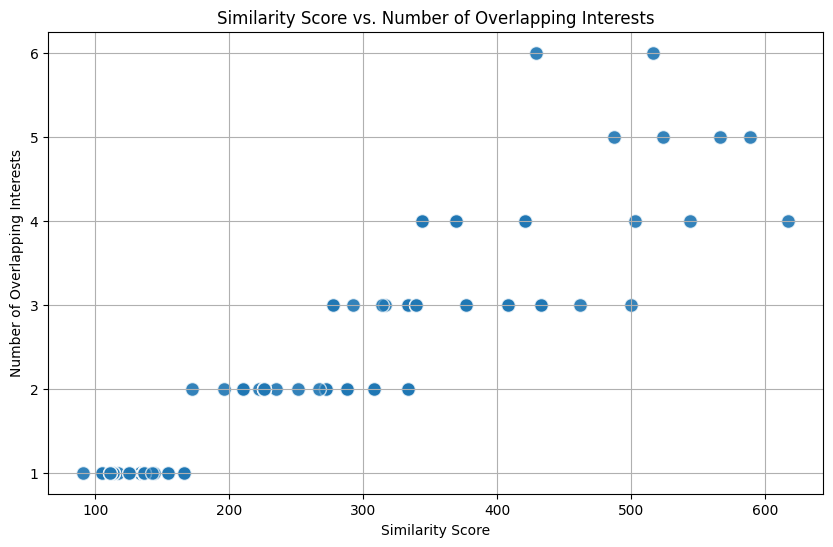

In [0]:
import matplotlib.pyplot as plt

similarity_scores, overlap_counts = validate_user_user_recommendations(recommendations_df)

# Plot the data.
plt.figure(figsize=(10, 6))
plt.scatter(similarity_scores, overlap_counts, alpha=0.7, edgecolors='w', s=100)
plt.xlabel("Similarity Score")
plt.ylabel("Number of Overlapping Interests")
plt.title("Similarity Score vs. Number of Overlapping Interests")
plt.grid(True)
plt.show()

In [0]:

# convert recommendations_df to json serializable dictionary 
records = recommendations_df.to_dict(orient='records')

# don't uncomment the following line until you're absolutely ready
response = supabase.table("user_user_recommendations").insert(records).execute()


In [0]:
# start of collaborative filtering workflow (not necessary for MVP)

user_interest_matrix = user_interest_matrix_unprocessed.copy()

# remapping the user_id to be n_users - 1 (to work with sparse matrix) 
user_interest_matrix.index = user_interest_matrix.index.map(lambda uid: new_user_id_map[uid])
user_interest_matrix.index.name = None
user_interest_matrix.index.name = "user_id"
user_interest_matrix

In [0]:
# remapping interest_id to be n_interests to work with sparse matrix 
user_interest_matrix.rename(columns=new_interest_id_map, inplace=True)
user_interest_matrix